In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Try with nbodykit

In [2]:
from nbodykit.lab import *
from nbodykit import style,setup_logging

In [3]:
qpm_cosmo = cosmology.Cosmology(h=0.7,Omega0_b=0.0458,Omega0_cdm=0.29-0.0458,n_s=0.97,sigma8=0.7,nonlinear=False)
Plin = cosmology.LinearPower(qpm_cosmo,0.55,transfer='CLASS')

In [4]:
two_pcf = cosmology.CorrelationFunction(Plin)

In [5]:
r_all = np.linspace(0.001,400,200)
mu_all = np.arange(0.,1.05,0.05)
xi_all = two_pcf(r_all)

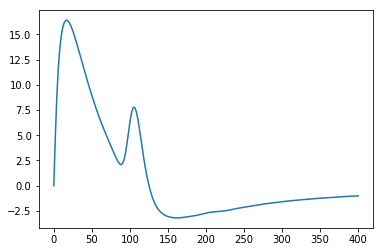

In [6]:
plt.plot(r_all,two_pcf(r_all)*r_all**2)

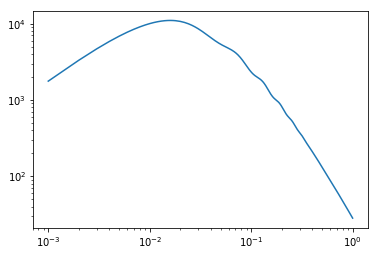

In [7]:
plt.plot(np.arange(0.001,1,.001),Plin(np.arange(0.001,1,.001)))
plt.yscale('log')
plt.xscale('log')

### Save 2PCFs to file

In [8]:
with open('/mnt/store1/oliverphilcox/GRFs_true/lin_xi.xi',"w") as out:
    for r in r_all:
        out.write("%.8e "%r)
    out.write("\n")
    for mu in mu_all:
        out.write("%.8e "%mu)
    out.write("\n")
    for i in range(len(r_all)):
        for j in range(len(mu_all)):
            out.write("%.8e "%xi_all[i])
        out.write("\n")

In [9]:
boxsize = 1000
V = boxsize**3

##### Using Flipper code

In [32]:
N_k = 256
boxsize = 1000

realPart = np.zeros([N_k,N_k,N_k])
imgPart = np.zeros([N_k,N_k,N_k])

kx = np.fft.fftfreq(N_k,boxsize/N_k)*(2.*np.pi)
ky = np.fft.fftfreq(N_k,boxsize/N_k)*(2.*np.pi)
kz = np.fft.fftfreq(N_k,boxsize/N_k)*(2.*np.pi)

modkMap = np.zeros([N_k,N_k,N_k])
iz,iy,ix = np.mgrid[0:N_k,0:N_k,0:N_k]
modkMap[iz,iy,ix] = np.sqrt(kx[ix]**2+ky[iy]**2+kz[iz]**2)

pMap = Plin(modkMap)/V*N_k**6

In [33]:
realPart = np.sqrt(pMap)*np.random.randn(N_k,N_k,N_k)
imgPart = np.sqrt(pMap)*np.random.randn(N_k,N_k,N_k)

kMap = realPart+1j*imgPart

data = np.real(np.fft.ifftn(kMap))

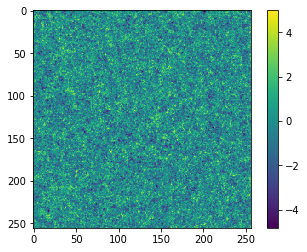

In [34]:
plt.imshow(data[0])
plt.colorbar()

In [13]:
n_bar = 3e-5
vol_box = (boxsize/N_k)**3
exp_N_gal = vol_box*n_bar*(1.+data)

In [14]:
exp_N_gal[exp_N_gal<0]=0
N_gal = np.random.poisson(lam=exp_N_gal)

gal_jitter = np.random.uniform(size=(N_gal.sum(),3))*(boxsize/N_k)

In [15]:
occupations = N_gal.ravel()

In [16]:
## Define coordinates of cell edges
lz,ly,lx = np.mgrid[0:N_k,0:N_k,0:N_k]*(boxsize/N_k)
cell_edges = np.vstack([lx.ravel(),ly.ravel(),lz.ravel()]).T

In [17]:
out_pos = np.zeros([N_gal.sum(),3])
ii=0

for i in range(len(occupations)):
    if occupations[i]!=0:
        for o in range(occupations[i]):
            out_pos[ii]=cell_edges[i]+gal_jitter[ii]
            ii+=1


In [18]:
ran_par = np.random.uniform(size=(int(n_bar*V*10),3))*boxsize

In [19]:
from Corrfunc.theory import DD
r_bins_cf = np.arange(10,150,10)
DD_ct=DD(1,20,r_bins_cf,out_pos[:,0],out_pos[:,1],out_pos[:,2],weights1=np.ones(len(out_pos))*1.,
         periodic=False,weight_type='pair_product')

DD_out = DD_ct['npairs']*DD_ct['weightavg']

DR_ct=DD(0,20,r_bins_cf,out_pos[:,0],out_pos[:,1],out_pos[:,2],weights1=np.ones(len(out_pos)),
         X2 = ran_par[:,0],Y2=ran_par[:,1],Z2=ran_par[:,2],weights2=np.ones(len(ran_par))/10.,
         periodic=False,weight_type='pair_product')

DR_out = DR_ct['npairs']*DR_ct['weightavg']

RR_ct=DD(1,20,r_bins_cf,ran_par[:,0],ran_par[:,1],ran_par[:,2],
         weights1=np.ones(len(ran_par))/10.,periodic=False,weight_type='pair_product')

RR_out = RR_ct['npairs']*RR_ct['weightavg']

countpairs_double> gridlink seems inefficient. nmesh = (14, 14, 7); avg_np = 457. Boosting bin refine factor - should lead to better performance
xmin = 0.001685 xmax=999.999996 rpmax = 140.000000
countpairs_double> gridlink seems inefficient. nmesh = (14, 14, 7); avg_np = 457. Boosting bin refine factor - should lead to better performance
xmin = 0.000597 xmax=999.999996 rpmax = 140.000000


In [21]:
len(ran_par)/len(out_pos)

0.47853758912762595

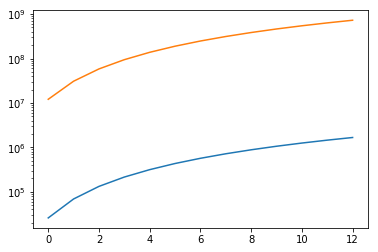

In [22]:
plt.plot(RR_out)
plt.plot(DD_out)
plt.yscale('log')

In [23]:
xi_est = (DD_out-2*DR_out+RR_out)/RR_out

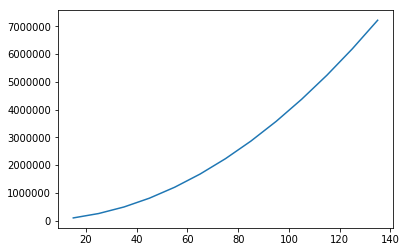

In [24]:
r_bins_out = (r_bins_cf[1:]+r_bins_cf[:-1])/2.
plt.plot(r_bins_out,r_bins_out**2*xi_est)

([array([63018., 62193., 62793., 62575., 62696., 63153., 62602., 62627.,
         63932., 61321.]),
  array([62800., 62896., 62648., 62419., 61740., 63563., 62050., 62356.,
         63422., 63016.]),
  array([63111., 62677., 63689., 62385., 62535., 62895., 62812., 62302.,
         61735., 62769.])],
 array([1.00868702e-03, 1.00000907e+02, 2.00000806e+02, 3.00000705e+02,
        4.00000604e+02, 5.00000502e+02, 6.00000401e+02, 7.00000300e+02,
        8.00000199e+02, 9.00000097e+02, 9.99999996e+02]),
 <a list of 3 Lists of Patches objects>)

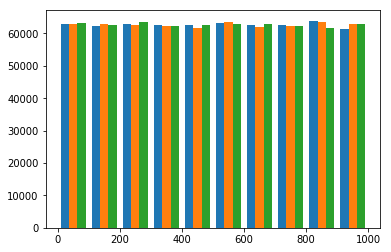

In [25]:
plt.hist(out_pos)

In [ ]:
plt.hist(N_gal[:,0,0])

In [ ]:
np.sum(N_gal)

In [ ]:
boxsize=1000
nbar = 3e-4
out_dir = '/mnt/store1/oliverphilcox/GRFs_true/'

import pmesh
from nbodykit.mockmaker import gaussian_real_fields,poisson_sample_to_points
## Mesh must be much larger than points
mesh = pmesh.pm.ParticleMesh([128,128,128],BoxSize=boxsize*2)

In [ ]:
for i in range(80,300):
    print("Computing mock %d of %d"%(i+1,300))
    seed = i
    delta_field,disp_field = gaussian_real_fields(mesh,Plin,seed,compute_displacement=True)
    rand_pos,rand_disp = poisson_sample_to_points(delta_field,disp_field,mesh,nbar,seed=seed)
    
    ## Add displacement vector
    rand_pos+=rand_disp
    
    ## Select points far from boundaries    
    filt = np.where(np.abs(rand_pos[:,0]-boxsize)<=boxsize/2)
    rand_pos = rand_pos[filt]
    filt2 = np.where(np.abs(rand_pos[:,1]-boxsize)<=boxsize/2)
    rand_pos = rand_pos[filt2]
    filt3 = np.where(np.abs(rand_pos[:,2]-boxsize)<=boxsize/2)
    rand_pos = rand_pos[filt3]
    # shift center
    rand_pos-=np.ones(rand_pos.shape)*boxsize/2
    rand_disp = rand_disp[filt][filt2][filt3]
    
    rand_w = np.ones([len(rand_pos),1])*1.
    rand_dat = np.hstack([rand_pos,rand_w])

    with open(out_dir+'mock_%d'%i,'w') as outfile:
        for g in range(len(rand_dat)):
            l=rand_dat[g]
            outfile.write("%.8e %.8e %.8e %.8e\n"%(l[0],l[1],l[2],l[3]))

In [ ]:
n_gal = nbar*boxsize**3
n_rand = int(1.5*n_gal)
for i in range(32):
    this_rand = np.random.random(size=(n_rand,4))*boxsize
    this_rand[:,-1]=-1.*n_gal/n_rand # weights
    with open(out_dir+'ran_%d'%i,'w') as outfile:
        for g in range(n_rand):
            l=this_rand[g]
            outfile.write("%.8e %.8e %.8e %.8e\n"%(l[0],l[1],l[2],l[3]))

In [ ]:
n_gal = nbar*boxsize**3
n_rand_all = int(48*n_gal)
this_rand = np.random.random(size=(n_rand_all,4))*boxsize
this_rand[:,-1]=1. # weights
with open(out_dir+'tot_ran','w') as outfile:
    for g in range(n_rand_all):
        l=this_rand[g]
        outfile.write("%.8e %.8e %.8e %.8e\n"%(l[0],l[1],l[2],l[3]))

### Generate GRFs

In [ ]:
# all_cat=[]
# boxsize=500
# nbar = 3e-5
# for i in range(300):
#     print("Computing catalog %d of %d"%(i+1,100))
#     cat = LogNormalCatalog(Plin=Plin, cosmo=qpm_cosmo, nbar=nbar, BoxSize=boxsize, Nmesh=128, bias=2.0, seed=i)
#     cat_pos=cat.Position().compute()
#     cat_w = cat.Weight().compute().reshape(-1,1)
#     out_dat = np.hstack([cat_pos,cat_w])
#     all_cat.append(out_dat)
    
#     out_dir = '/mnt/store1/oliverphilcox/GRFs_per/'
#     with open(out_dir+'mock_%d'%i,'w') as outfile:
#         for g in range(len(out_dat)):
#             l=out_dat[g]
#             outfile.write("%.8e %.8e %.8e %.8e\n"%(l[0],l[1],l[2],l[3]))

### Create Random Catalog

In [ ]:
# n_rand = int(1.5*len(all_cat[0]))
# for i in range(32):
#     this_rand = np.random.random(size=(n_rand,4))*boxsize
#     this_rand[:,-1]=-1. # weights
#     with open(out_dir+'ran_%d'%i,'w') as outfile:
#         for g in range(n_rand):
#             l=this_rand[g]
#             outfile.write("%.8e %.8e %.8e %.8e\n"%(l[0],l[1],l[2],l[3]))

### Define Inverse Phi

In [ ]:
# phi_inv_norm = 6.*nbar**3*boxsize**3
# phi_inv=np.zeros([15*15,7])
# phi_inv[:,0]=phi_inv_norm
# np.savetxt("/mnt/store1/oliverphilcox/GRFs/phi_inv",phi_inv,fmt="%.8e",delimiter='\t')

In [ ]:
import re
def reader(file_name,n=18,max_l=4):
    
    dat = np.zeros([n,n,max_l+1])

    with open(file_name) as f:
        start=False
        for line in f:
            if not start:
                if re.match("# Multipole",line):
                    start=True
                continue
            if re.match("Multipole",line):
                continue
            if len(line.split())==0:
                start=False
                continue
            if re.match('# Saving',line):
                start=False
                continue
            x=line.split()
            b1=int(x[0])
            b2=int(x[1])
            dat[b1,b2,0]=float(x[2])/2.
            if b1!=b2:
                dat[b2,b1,0]=float(x[2])/2.
            for ell in range(1,max_l+1):
                dat[b1,b2,ell]=float(x[ell+2])*float(x[2])*(2.*ell+1.)/2.
                if b1!=b2:
                    dat[b2,b1,ell]=float(x[ell+2])*float(x[2])*(2.*ell+1.)/2.
    return dat;

In [ ]:
DR_m=reader('/home/oliverphilcox/3pcf_code/codes/grid_multipoles/tmp_DR_mult')
DR_no_m = reader('/home/oliverphilcox/3pcf_code/codes/grid_multipoles/tmp_DR_no_mult')

In [ ]:
all_rrr=reader('/mnt/store1/oliverphilcox/GRFs_per_rare/rrr_out')
rrr=all_rrr[3:,3:,:]*6 # correction factor for SE vs our definitions

max_l = 4
r_lo = np.arange(30,171,10)
r_hi = np.arange(40,181,10)

vol = lambda a: 4.*np.pi/3.*(r_hi[a]**3-r_lo[a]**3)

def phi_model(bin_a,bin_b,ell):
    if ell>max_l:
        return 0.
    else:
        return rrr[bin_a,bin_b,ell]/(3.*nbar**3*boxsize**3*vol(bin_a)*vol(bin_b))

In [ ]:
inv_phi = np.zeros([15,15,7])
for i in range(len(rrr)):
    for j in range(len(rrr)):
        for ell in range(7):
            #inv_phi[i,j,ell]=phi_model(i,j,ell)*(6.*nbar**3*boxsize**3)
            # set to 1 for periodic box
            inv_phi[i,j,ell]=(ell==0)*(6.*nbar**3*boxsize**3)

In [ ]:
with open('/mnt/store1/oliverphilcox/GRFs_aper_dense_big/phi_inv','w') as out:
    for i in range(len(inv_phi)):
        for j in range(len(inv_phi)):
            for ell in range(7):
                out.write("%.6e"%inv_phi[i,j,ell])
                if ell<6:
                    out.write("\t")
                else:
                    out.write("\n");        

In [ ]:
plt.plot(inv_phi[:,:,0]);